# Develop GANs Using Keras

We will gain practical experience in developing generative adversarial networks (GANs) using Keras. We will learn to preprocess data, construct the generator and discriminator models, combine them to create the GAN, train the GAN, and evaluate its performance. GANs are powerful tools for generating synthetic data, and this notebook will provide a solid foundation for further exploration and experimenation with more advanced GAN architectures and applications.

 - Build, train, and evaluate GANs using Keras
 - Explore GAN architectures, data preprocessing, model training, and performance evaluation.

#### Step 1: Data preprocessing

1. Load images
 - Normalize the image pixel values to the range [-1, 1].

2. Reshape the data:
 - Expand the dimensions of the images to match the input shape required by GAN.

In [164]:
import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [165]:
def test_image_loading(folder_path="O"):
    """
    Test loading each image to find the problematic one
    """
    print("\n🧪 TESTING EACH IMAGE:")
    print("="*50)
    
    image_paths = list(pathlib.Path(folder_path).glob("*.jpg"))
    
    good_images = []
    bad_images = []
    
    for i, path in enumerate(image_paths):
        try:
            # Test with TensorFlow
            img = tf.io.read_file(str(path))
            img = tf.image.decode_jpeg(img, channels=3)
            print(f"✅ {i+1:3d}: {path.name}")
            good_images.append(path)
            
        except Exception as e:
            print(f"❌ {i+1:3d}: {path.name} - ERROR: {str(e)}")
            bad_images.append(path)
    
    print(f"\nSummary:")
    print(f"Good images: {len(good_images)}")
    print(f"Bad images: {len(bad_images)}")
    
    if bad_images:
        print(f"\nProblematic files:")
        for bad_path in bad_images:
            print(f"  {bad_path}")
    
    return good_images, bad_images


test_image_loading('O')



🧪 TESTING EACH IMAGE:
✅   1: 1.jpg
✅   2: 10.jpg
✅   3: 11.jpg
✅   4: 12.jpg
✅   5: 13.jpg
✅   6: 14.jpg
✅   7: 15.jpg
✅   8: 16.jpg
✅   9: 17.jpg
✅  10: 18.jpg
✅  11: 2.jpg
✅  12: 20.jpg
✅  13: 21.jpg
✅  14: 22.jpg
✅  15: 23.jpg
✅  16: 25.jpg
✅  17: 26.jpg
✅  18: 29.jpg
✅  19: 3.jpg
✅  20: 31.jpg
✅  21: 32.jpg
✅  22: 33.jpg
✅  23: 37.jpg
✅  24: 38.jpg
✅  25: 39.jpg
✅  26: 4.jpg
✅  27: 40.jpg
✅  28: 41.jpg
✅  29: 42.jpg
✅  30: 43.jpg
✅  31: 44.jpg
✅  32: 45.jpg
✅  33: 46.jpg
✅  34: 47.jpg
✅  35: 48.jpg
✅  36: 49.jpg
✅  37: 5.jpg
✅  38: 50.jpg
✅  39: 6.jpg
✅  40: 7.jpg
✅  41: 8.jpg

Summary:
Good images: 41
Bad images: 0


([WindowsPath('O/1.jpg'),
  WindowsPath('O/10.jpg'),
  WindowsPath('O/11.jpg'),
  WindowsPath('O/12.jpg'),
  WindowsPath('O/13.jpg'),
  WindowsPath('O/14.jpg'),
  WindowsPath('O/15.jpg'),
  WindowsPath('O/16.jpg'),
  WindowsPath('O/17.jpg'),
  WindowsPath('O/18.jpg'),
  WindowsPath('O/2.jpg'),
  WindowsPath('O/20.jpg'),
  WindowsPath('O/21.jpg'),
  WindowsPath('O/22.jpg'),
  WindowsPath('O/23.jpg'),
  WindowsPath('O/25.jpg'),
  WindowsPath('O/26.jpg'),
  WindowsPath('O/29.jpg'),
  WindowsPath('O/3.jpg'),
  WindowsPath('O/31.jpg'),
  WindowsPath('O/32.jpg'),
  WindowsPath('O/33.jpg'),
  WindowsPath('O/37.jpg'),
  WindowsPath('O/38.jpg'),
  WindowsPath('O/39.jpg'),
  WindowsPath('O/4.jpg'),
  WindowsPath('O/40.jpg'),
  WindowsPath('O/41.jpg'),
  WindowsPath('O/42.jpg'),
  WindowsPath('O/43.jpg'),
  WindowsPath('O/44.jpg'),
  WindowsPath('O/45.jpg'),
  WindowsPath('O/46.jpg'),
  WindowsPath('O/47.jpg'),
  WindowsPath('O/48.jpg'),
  WindowsPath('O/49.jpg'),
  WindowsPath('O/5.jpg'),
  Wind

In [166]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import pathlib

# load all image paths
image_paths = list(pathlib.Path("O").glob("*.jpg"))

# split 80/20
train_size = int(0.8 * len(image_paths))
train_paths, test_paths = image_paths[:train_size], image_paths[train_size:]

# function to load, resize, normalize
def load_and_preprocess(path):
    img = tf.io.read_file(str(path))
    img = tf.image.decode_jpeg(img, channels=3)           # RGB (3 channel)
    img = tf.image.resize(img, (128, 128))                  # resize to 128x128
    img = tf.cast(img, tf.float32) / 127.5 - 1.0  # normalize to [-1,1]
    return img.numpy()

# load into numpy arrays
x_train = np.array([load_and_preprocess(p) for p in train_paths])
x_test  = np.array([load_and_preprocess(p) for p in test_paths])

# no labels
y_train = y_test = None

print(x_train.shape)  # e.g. (num_train, 128, 128, 1)
print(x_test.shape)   # e.g. (num_test, 128, 128, 1)

def augment_pineapple_data(x_train):
    """
    Increase 41 images to ~200+ through augmentation
    """
    print("🍍 AUGMENTING PINEAPPLE DATA:")
    print("="*50)
    
    augmented_data = []
    
    for img in x_train:
        # Original image
        augmented_data.append(img)
        
        # Horizontal flip
        flipped = tf.image.flip_left_right(img)
        augmented_data.append(flipped.numpy())
        
        # Slight rotations
        for angle in [0.1, -0.1, 0.2, -0.2]:  # Small rotations in radians
            rotated = tf.image.rot90(img, k=1)  # 90 degree rotation
            augmented_data.append(rotated.numpy())
        
        # Brightness variations
        for brightness in [0.1, -0.1]:
            bright = tf.image.adjust_brightness(img, brightness)
            bright = tf.clip_by_value(bright, -1, 1)  # Keep in [-1,1] range
            augmented_data.append(bright.numpy())
        
        # Small crops and resize
        for i in range(2):
            # Random crop
            cropped = tf.image.random_crop(img, [120, 120, 3])
            resized = tf.image.resize(cropped, [128, 128])
            augmented_data.append(resized.numpy())
    
    augmented = np.array(augmented_data)
    print(f"Original dataset: {len(x_train)} images")
    print(f"Augmented dataset: {len(augmented)} images")
    
    return augmented

x_train_augmented = augment_pineapple_data(x_train)
print(x_train_augmented.shape)  # e.g. (num_train, 128, 128, 1)


(32, 128, 128, 3)
(9, 128, 128, 3)
🍍 AUGMENTING PINEAPPLE DATA:
Original dataset: 32 images
Augmented dataset: 320 images
(320, 128, 128, 3)


In [167]:
x_train_augmented = tf.image.resize(x_train_augmented, (32, 32)).numpy()
print(x_train_augmented.shape)  # e.g. (num_train, 128, 128, 1)


(320, 32, 32, 3)


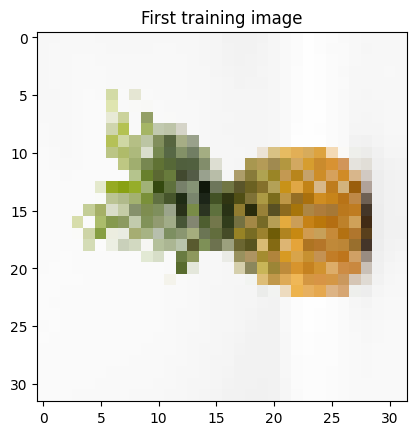

Shape: (32, 32, 3)
Red channel range: [-0.870, 0.992]
Green channel range: [-0.810, 0.992]
Blue channel range: [-0.940, 0.992]


In [168]:
# Test if your strawberries have color:
import matplotlib.pyplot as plt
sample = x_train_augmented[5]
plt.imshow((sample + 1) / 2)  # Convert [-1,1] back to [0,1] for display
plt.title("First training image")
plt.show()
print(f"Shape: {sample.shape}")
print(f"Red channel range: [{sample[:,:,0].min():.3f}, {sample[:,:,0].max():.3f}]")
print(f"Green channel range: [{sample[:,:,1].min():.3f}, {sample[:,:,1].max():.3f}]")
print(f"Blue channel range: [{sample[:,:,2].min():.3f}, {sample[:,:,2].max():.3f}]")

In the code above we prepared the dataset for training by normzaliing the pixel values to the range [-1, 1] (standard and recommended approach). Normalization helps in faster convergence during training, and reshaping is required because the input layer of our GAN expects a three-dimentsional tensor.

#### Step 2: Building the generator model

Construct the generator model for the GAN using the Keras functional API.

1. Define the generator.
 - Create a Sequential model.
 - Add Dense, LeakyReLU, BatchNormalization, and Reshape layers to build the generator.

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Conv2D, UpSampling2D

# Define the generator model
# def build_generator():
#     model = Sequential()
#     model.add(Dense(256, input_dim=100))
#     model.add(LeakyReLU(alpha=0.2))
#      # above two lines = model.add(Dense(256, activation=LeakyReLU(alpha=0.2)))  # Still need BatchNorm separately
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(1024))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(128*128*3, activation='tanh'))
#     model.add(Reshape((128, 128, 3)))  
#     return model

latent_dim=100

# def build_generator():
#     model = Sequential()
#     # Step 1: Dense layer - Convert noise to feature representation
#     model.add(Dense(8*8*512, input_dim=latent_dim))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8)) # Stabalize training
#     # Step 2: Reshape to 3D tensor
#     model.add(Reshape((8, 8, 512)))
#     # Step 3: Upsampling Block 1 (8x8 -> 16x16)
#     model.add(UpSampling2D())
#     model.add(Conv2D(256, kernel_size=3, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     # Step 4: Upsampling Block 2
#     model.add(UpSampling2D())
#     model.add(Conv2D(128, kernel_size=3, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     # Step 5: Upsampling Block 3
#     model.add(UpSampling2D())
#     model.add(Conv2D(64, kernel_size=3, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     # Step 6: Upsampling Block 4
#     model.add(UpSampling2D())
#     model.add(Conv2D(32, kernel_size=3, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     # Step 7: Final Output Layer
#     # Convert to actual RGB image (3 channels)
#     # tanh gives values between -1 and 1 (good for image data)
#     model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
#     return model

def build_generator():
    model = Sequential()
    # Step 1: Dense layer - Convert noise to feature representation
    model.add(Dense(8*8*512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # Step 2: Reshape to 3D tensor
    model.add(Reshape((8, 8, 512)))
    # Step 3: Upsampling Block 1 (8x8 -> 16x16)
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # Step 4: Upsampling Block 2 (16x16 -> 32x32)
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # Step 5: Final Output Layer - STOP HERE FOR 32x32
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    return model
    

# Build the generator
generator = build_generator()
generator.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_130 (LeakyReLU)  (None, 32768)             0         
_________________________________________________________________
batch_normalization_106 (Bat (None, 32768)             131072    
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 16, 16, 256)       1179904   
_________________________________________________________________
leaky_re_lu_131 (LeakyReLU)  (None, 16, 16, 256)     

This step involves building the generator model for the GAN. The generator takes a random noise vector as an input and generates a synthetic image. The model uses Dense, LeakyRelu, BatchNormalization, and Reshape layers to achieve this. 

#### Step 3: Building the discriminator model

Construct the discriminator model for the GAN using the Keras functional API.

1. Define the discriminator
 - Create a Sequential model. 
 - Add Flatten, Dense, and LeakyReLU layers to build the discriminator.

2. Compile the discriminator.
 - Compile the model using binary cross-entropy loss and the Adam optimizer.

In [170]:
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam


# Define the discriminator model
# def build_discriminator():
#     model = Sequential()
#     model.add(Flatten(input_shape=(128, 128, 3)))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(256))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dense(1, activation='sigmoid'))
#     return model

# def build_discriminator():
#     model = Sequential()
#     # Block 1: 128x128 -> 64x64
#     model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(128, 128, 3), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.5))  # Prevents overfitting
#     print("After block 1: 64x64x32")
    
#     # Block 2: 64x64 -> 32x32
#     model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization(momentum=0.8))
#     print("After block 2: 32x32x64")
    
#     # Block 3: 32x32 -> 16x16
#     model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization(momentum=0.8))
#     print("After block 3: 16x16x128")
    
#     # Block 4: 16x16 -> 8x8
#     model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization(momentum=0.8))
#     print("After block 4: 8x8x256")
    
#     # Block 5: 8x8 -> 4x4
#     model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization(momentum=0.8))
#     print("After block 5: 4x4x512")
    
#     # Final layers: Convert to single probability
#     model.add(Flatten())  # 4*4*512 = 8,192 numbers
#     model.add(Dense(1, activation='sigmoid'))  # Real (1) or Fake (0)
#     print("Final output: 1 (probability)")
    
#     return model

def build_discriminator():
    model = Sequential()
    # Block 1: 32x32 -> 16x16 (CHANGED from 128x128)
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    print("After block 1: 16x16x32")
    
    # Block 2: 16x16 -> 8x8
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization(momentum=0.8))
    print("After block 2: 8x8x64")
    
    # Block 3: 8x8 -> 4x4
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(BatchNormalization(momentum=0.8))
    print("After block 3: 4x4x128")
    
    # REMOVE the extra blocks - you don't need them for 32x32 input
    
    # Final layers
    model.add(Flatten())  # 4*4*128 = 2,048 numbers
    model.add(Dense(1, activation='sigmoid'))
    print("Final output: 1 (probability)")
    
    return model

d_optimizer = Adam(learning_rate=0.00007)  # Half speed

# Build and compile the discriminator 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=d_optimizer, metrics=['accuracy'])
discriminator.summary()



After block 1: 16x16x32
After block 2: 8x8x64
After block 3: 4x4x128
Final output: 1 (probability)
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_133 (LeakyReLU)  (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_134 (LeakyReLU)  (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 8, 8, 64)          0         
____________________

This step involved building the discriminator model for the GAN. The disriminator takes an image as an input and outputs a probability indicating whether the image is real or fake. The model uses Flatten, Dense, and LeakyReLU layers to achieve this. 

#### Step 4: Building the GAN Model

Combine the generator and discriminator to create the GAN model using the Keras functional API.

1. Define the GAN.
 - Create an input layer for the noise vector.
 - Pass the noise vector though the generator to produce a synthetic image.
 - Pass the synthetic image thorugh the discriminator to get the classficiation.
 - Compile the GAN using binary corss-entropy loss and the Adam optimizer.

In [171]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Create the GAN by stacking the generator and the discriminator 
# def build_gan(generator, discriminator):
#     discriminator.trainable = False
#     gan_input = Input(shape=(100,))
#     generated_image = generator(gan_input)
#     gan_output = discriminator(generated_image)
#     gan = Model(gan_input, gan_output)
#     gan.compile(loss='binary_crossentropy', optimizer='adam')
#     return gan

def build_gan(generator, discriminator):
    # Step 1: Freeze discriminator (same as yours)
    discriminator.trainable = False
    
    # Step 2: Build the model architecture (same as yours)
    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = Model(gan_input, gan_output)
    
    # Step 3: Better optimizer settings for GAN training
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)  # Better than default 'adam'

    g_optimizer = Adam(learning_rate=0.0004)  # Normal
    gan.compile(loss='binary_crossentropy', optimizer=g_optimizer)
    return gan

# Build the GAN
gan = build_gan(generator, discriminator)
gan.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_35 (Sequential)   (None, 32, 32, 3)         4920579   
_________________________________________________________________
sequential_36 (Sequential)   (None, 1)                 96065     
Total params: 5,016,644
Trainable params: 4,854,275
Non-trainable params: 162,369
_________________________________________________________________


How It Works:

    Takes random noise → Expands through Dense layers
    Learns patterns from your real image dataset during training
    Generates fake images that look similar to real ones
    Goal: Fool the discriminator into thinking fake images are real

The Magic:

    Same noise → Same fake image (deterministic)
    Different noise → Different fake image
    After training, it learns to create realistic-looking images from pure randomness!

This step involves combining the generator and discriminator models to create the GAN. The GAN takes a noise vector as an input, generates a synthetic image using the generator, and classifies the image using the discriminator. The discriminator is set to non-trainable when compiling the GAN to ensure that only the generator is updated during the adversarial training. 

#### Step 5: Training the GAN

Train the GAN on our dataset.

1. Define training parameters.
    - Set the batch size, number of epochs, and sample interval.

2. Train the discriminator.
    - Sample a batchs of real images from the dataset.
    - Generate a batch of synthetic images from the generator.
    - Train the discriminator on both real and generated images.

3. Train the generator.
    - Generate a batch of noise vectors.
    - Train the GAN to improve the generator's ability to fool the discriminator. 

4. Print the progrss:
    - Print the discriminator and generator losses at regular intervals.

In [172]:
batch_size = 32
epochs = 80
sample_interval = 10

# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Training loop
for epoch in range(epochs):
    # Train the discriminator
    idx = np.random.randint(0, x_train_augmented.shape[0], batch_size)
    real_images = x_train_augmented[idx]
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(real_images, real)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, real)

    # Prin the progress 
    if epoch % sample_interval == 0:
        print(f" {epoch} [D loss: {d_loss[0]}] [D accuracy: {100 * d_loss[1]}%] [G loss: {g_loss}]")

 0 [D loss: 0.8189836740493774] [D accuracy: 45.3125%] [G loss: 0.7279362678527832]
 10 [D loss: 1.1049671471118927] [D accuracy: 37.5%] [G loss: 0.8931807279586792]
 20 [D loss: 0.9055431485176086] [D accuracy: 35.9375%] [G loss: 0.655125617980957]
 30 [D loss: 1.0735484957695007] [D accuracy: 37.5%] [G loss: 0.6752907037734985]
 40 [D loss: 1.0183650255203247] [D accuracy: 42.1875%] [G loss: 0.5324841737747192]
 50 [D loss: 1.02749502658844] [D accuracy: 46.875%] [G loss: 0.6438471078872681]
 60 [D loss: 1.0404762923717499] [D accuracy: 46.875%] [G loss: 0.45807644724845886]
 70 [D loss: 0.9282672703266144] [D accuracy: 56.25%] [G loss: 0.4962243437767029]


#### Step 6: Assessing the Quality of Generated Images

Evaluate the performance of the trained GAN.

##### Evaluate the GAN

After training the GAN, we need to assess the quality of the synthetic images generated by the generator. There are two main ways to evaluate the performance of GANs: qualitative assessment and quantitative assessment.

##### Qualitative Assessment: Visual Inspection 

Visual inspection is a straightforward method to assess the quality of images generated by a GAN. We can use the `sample_images` function provided in the lab to visualize a grid of generated images. During visual inspection, look for the following qualities: 

- **Clarity**: The images should be sharp and not blurry. Blurry images indicate that the generator is struggling to learn the patterns in the data.
- **Coherence**: The generated images should have a coherent structure that resembles the original images in the dataset. For example, in the case of our images, the generated images should resemble imagaes of fruits.
- **Diversity**: There should be a variety of images generated by the GAN. If all images look similar, it might indicate that the generator is overfitting or has collapsed to a single mode. 


1. Run the `sample_images` function after training the GAN to display a grid of generated images.
2. Inspect the images for clarity, coherence, and diversity.

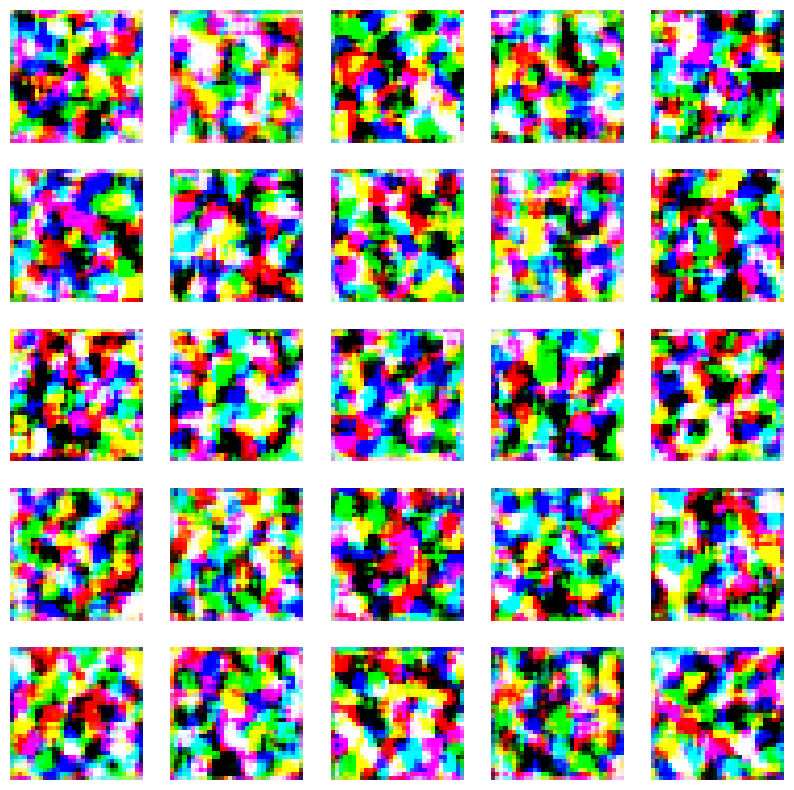

In [173]:
import matplotlib.pyplot as plt

def sample_images(generator, epoch, num_images=25):
    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]
    
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    count = 0

    for i in range(5):
        for j in range(5):
            # FIXED: Show all 3 channels (RGB) without grayscale colormap
            axs[i, j].imshow(generated_images[count])  # Remove [:, :, 0] and cmap='gray'
            axs[i, j].axis('off')
            count += 1
    plt.show()


# Sample images at the end of training
sample_images(generator, epochs)

I've tried to enhance the results by tuning numerous parameters but I think this is just a data quantity problem rather than a code problem

##### Quantitative Assessment: Metrics 

In [174]:
# Check what your models actually expect/produce
print("Generator output shape:", generator.output_shape)
print("Discriminator input shape:", discriminator.input_shape)

# Check your data shapes
print("x_train shape:", x_train_augmented.shape)
print("Generated images shape:", generated_images.shape)

Generator output shape: (None, 32, 32, 3)
Discriminator input shape: (None, 32, 32, 3)
x_train shape: (320, 32, 32, 3)
Generated images shape: (32, 32, 32, 3)


In [175]:
# Calculate and print the discriminator accuracy on real vs. fake images
noise = np.random.normal(0, 1, (batch_size, 100))
generated_images = generator.predict(noise)

# Evaluate the discriminator on real images
real_images = x_train_augmented[np.random.randint(0, x_train_augmented.shape[0], batch_size)]
d_loss_real = discriminator.evaluate(real_images, np.ones((batch_size, 1)), verbose=0)

# Evaluate the discriminator on fake images
d_loss_fake = discriminator.evaluate(generated_images, np.zeros((batch_size, 1)), verbose=0)

print(f"Discriminator Accuracy on Real Images: {d_loss_real[1] * 100:.2f}%")
print(f"Discriminator Accuracy on Fake Images: {d_loss_fake[1] * 100:.2f}%")


Discriminator Accuracy on Real Images: 100.00%
Discriminator Accuracy on Fake Images: 0.00%
